<a href="https://www.kaggle.com/code/mateorbt/finbert-embeddings-with-mlp?scriptVersionId=245117738" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
# Download necessary NLTK data
import nltk

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load and display the data


In [2]:
# Define the path to the manually downloaded dataset
data_path = "data/data.csv"  # Update the file name if it's different

# Check if the file exists before attempting to load
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset file not found at {data_path}. Ensure the file is in the correct location.")

# Load the dataset
df= pd.read_csv(data_path)
print("Dataset loaded successfully!")

# Display the first few rows of the DataFrame
df.head()


Dataset loaded successfully!


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


# Perform EDA 

# Display class disctribution

Class distribution:
Sentiment
neutral     3124
positive    1852
negative     860
Name: count, dtype: int64

Text length stats:
count    5836.000000
mean      116.964702
std        56.318951
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: text_length, dtype: float64


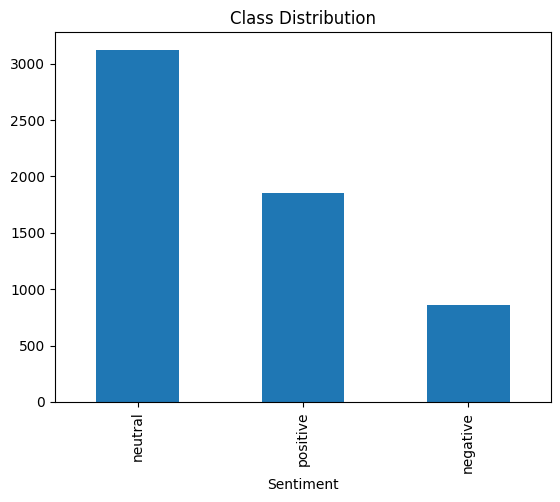

In [3]:
import matplotlib.pyplot as plt

# drop rows with missing values
df.dropna(inplace=True)
# Check for duplicates and remove them
df.drop_duplicates(inplace=True)

# Perform Exploratory Data Analysis (EDA)
def perform_eda(data):
    # Check class distribution
    print("Class distribution:")
    print(df['Sentiment'].value_counts())

    # Text length analysis
    df['text_length'] = df['Sentence'].apply(len)
    print("\nText length stats:")
    print(df['text_length'].describe())

    # Visualize class distribution
    df['Sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
    plt.show()
perform_eda(df)


# Preprocess the text data
In this section we will preprocess the text data by performing the following steps:
1. Remove extra whitespaces
2. Remove HTML tags
3. Remove URLs
4. Decode HTML entities
5. Replace stock tickers (e.g., $AAPL) with a special token 'STOCK'
6. Handle currencies (e.g., $10k, €20)
7. Remove space between digits and decimal points
8. Remove space before or after a comma in large numbers
9. Ensure that numbers with units (e.g., EUR 1.6 m) have no spaces
10. Replace percentages
11. Replace months, dates, years, and hours
12. Remove special characters
13. Tokenize the text
14. Remove punctuation
15. Remove stopwords
16. Apply stemming
17. Join tokens back into text

In [4]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import html
import string
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources if not already done
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_df(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Decode HTML entities
    text = html.unescape(text)

    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\S+|https\S+', 'url', text)

    # Strip leading/trailing whitespace
    return text.strip()
    

# Apply the cleaning function to the 'Sentence' column and create a new column 'cleaned_text'
df['cleaned_text'] = df['Sentence'].apply(clean_df)
df.head(100)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Sentence,Sentiment,text_length,cleaned_text
0,The GeoSolutions technology will leverage Bene...,positive,218,The GeoSolutions technology will leverage Bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,"$ESI on lows, down $1.50 to $2.50 BK a real po..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,"For the last quarter of 2010 , Componenta 's n..."
3,According to the Finnish-Russian Chamber of Co...,neutral,128,According to the Finnish-Russian Chamber of Co...
4,The Swedish buyout firm has sold its remaining...,neutral,135,The Swedish buyout firm has sold its remaining...
...,...,...,...,...
95,M-Real said there are ` no grounds ' for the r...,neutral,117,M-Real said there are ` no grounds ' for the r...
96,Lember said the matter was topical also in Est...,neutral,173,Lember said the matter was topical also in Est...
97,- Moody 's said it gave P A1 long-term senior ...,neutral,193,- Moody 's said it gave P A1 long-term senior ...
98,$TSLA recall,negative,12,$TSLA recall


# Handle imbalance
we will extract the embeddings from fibert then we will split the data to train and test and then we will use smote to handle the imbalance

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert").to(device)
model.eval()  # turn off dropout etc

def get_cls_embeddings(texts, tokenizer, model, max_length=160, batch_size=32):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encodings = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            embeddings.append(cls_embeddings.cpu())
    return torch.cat(embeddings).numpy()
#map the Sentiment labels to numerical values
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
df['label'] = df['Sentiment'].map(label_mapping)
# Prepare the texts and labels for embedding
texts = df['cleaned_text'].tolist()
labels = df['label'].tolist()

X_embeddings = get_cls_embeddings(texts, tokenizer, model)
y = np.array(labels)

print("Embeddings generated successfully!")
# add the embeddings to the DataFrame
df['embeddings'] = list(X_embeddings)
df.head()


c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torc

Embeddings generated successfully!


,Sentence,Sentiment,text_length,cleaned_text,label,embeddings
0,The GeoSolutions technology will leverage Bene...,positive,218,The GeoSolutions technology will leverage Bene...,0,"[0.17160298, 0.22198021, -0.54106945, -0.11608..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1,"[-0.55973333, 0.017466104, 0.5757842, -0.32641..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,"For the last quarter of 2010 , Componenta 's n...",0,"[0.9654906, -0.6212282, 0.10282654, -0.3271334..."
3,According to the Finnish-Russian Chamber of Co...,neutral,128,According to the Finnish-Russian Chamber of Co...,2,"[-0.017468307, 1.3972032, -0.45795882, -0.6200..."
4,The Swedish buyout firm has sold its remaining...,neutral,135,The Swedish buyout firm has sold its remaining...,2,"[-0.29055223, 0.09681258, -0.2711971, -0.75088..."


In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42, stratify=y)

#resample the training set using SMOTE
smote = SMOTE(
    sampling_strategy="not majority",  # Resample to balance the minority classes
    random_state=42
)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Check the class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution after resampling:
2    2499
0    2499
1    2499
Name: count, dtype: int64


# Now we will train a simple classifier

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Torch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Simple MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

model = MLPClassifier(input_dim=768, hidden_dim=256, output_dim=3).to(device)

# Function to evaluate the model
def evaluate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            total_loss += loss.item() * xb.size(0)  
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Loss Optimizer Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

epochs = 10

best_val_loss = float('inf')
patience = 3
counter = 0
stop_training = False

# save losses and accuracies for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    if stop_training:
        print("Early stopping triggered.")
        break

    model.train()
    total_loss = 0
    correct = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()

    val_loss, val_acc = evaluate_model(model, test_loader, criterion, device)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {correct/len(train_dataset):.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()  # Προαιρετικά: κρατάς το καλύτερο μοντέλο
    else:
        counter += 1
        if counter >= patience:
            stop_training = True
    # Save losses and accuracies for plotting
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / len(train_dataset))
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)





Epoch 1/10
Train Loss: 0.5313, Train Accuracy: 0.8006
Val Loss: 0.4317, Val Accuracy: 0.7997
Epoch 2/10
Train Loss: 0.4129, Train Accuracy: 0.8386
Val Loss: 0.3986, Val Accuracy: 0.8082
Epoch 3/10
Train Loss: 0.3916, Train Accuracy: 0.8463
Val Loss: 0.4424, Val Accuracy: 0.8099
Epoch 4/10
Train Loss: 0.3810, Train Accuracy: 0.8499
Val Loss: 0.4107, Val Accuracy: 0.8099
Epoch 5/10
Train Loss: 0.3662, Train Accuracy: 0.8565
Val Loss: 0.3937, Val Accuracy: 0.8151
Epoch 6/10
Train Loss: 0.3609, Train Accuracy: 0.8567
Val Loss: 0.3984, Val Accuracy: 0.8159
Epoch 7/10
Train Loss: 0.3500, Train Accuracy: 0.8615
Val Loss: 0.4145, Val Accuracy: 0.8176
Epoch 8/10
Train Loss: 0.3451, Train Accuracy: 0.8659
Val Loss: 0.3971, Val Accuracy: 0.8151
Early stopping triggered.


              precision    recall  f1-score   support

           0       0.87      0.89      0.88       371
           1       0.51      0.85      0.64       172
           2       0.95      0.76      0.85       625

    accuracy                           0.82      1168
   macro avg       0.78      0.83      0.79      1168
weighted avg       0.86      0.82      0.83      1168



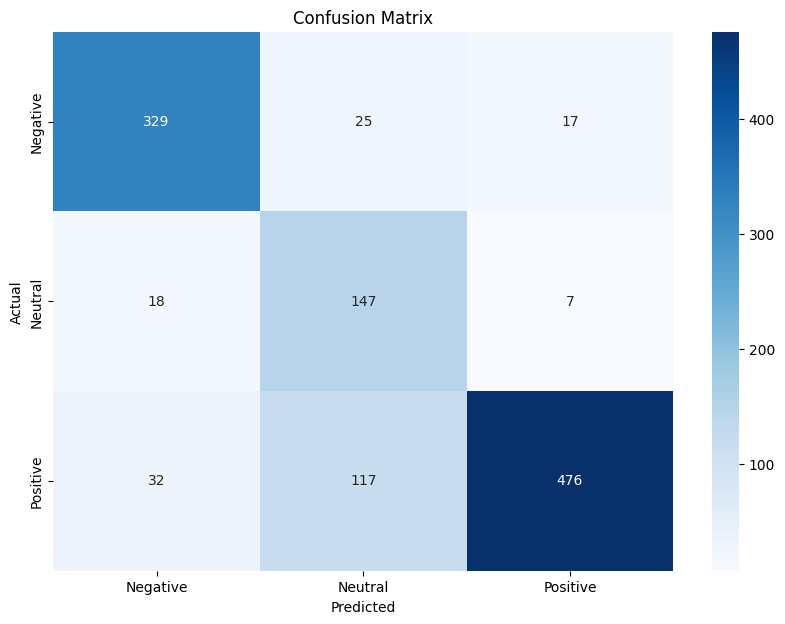

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print(classification_report(all_labels, all_preds))

# confiusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8151
F1 Score: 0.7871
Precision: 0.7762
Recall: 0.8343


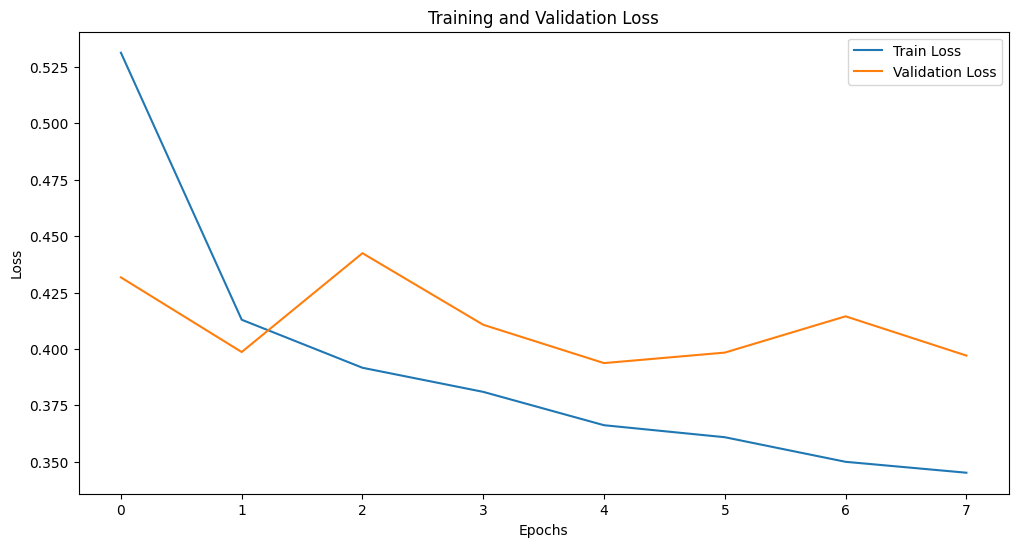

In [10]:
# plot training loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# print model architecture
print(model)

MLPClassifier(
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)
